In [1]:
import sys
import os
import pandas as pd
from ema_workbench.analysis.parcoords import ParallelAxes, get_limits
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 5]
sys.path.append("..")

/Users/aas6791/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [2]:
import rbf_functions
from rbf_functions import rbfs

In [3]:
rbfs = [
    rbf_functions.squared_exponential_rbf,
    rbf_functions.original_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

# Load reference set for each RBF
pareto_sets = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = "./refsets/"
    results = pd.read_csv(output_dir + name + "_refset.csv")
    results["environment"] = 1 - results["environment"]
    pareto_sets[name] = results

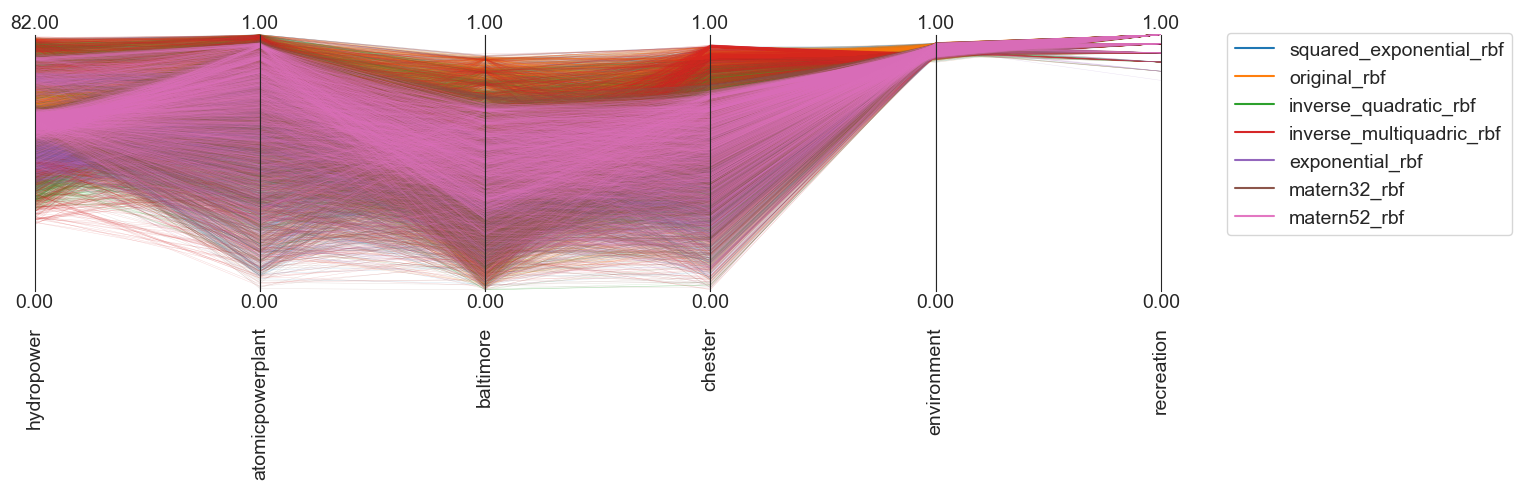

In [4]:
limits = get_limits(pd.concat(pareto_sets.values()))
limits.loc[0] = [0, 0, 0, 0, 0, 0]
limits.loc[1] = [82, 1, 1, 1, 1, 1]
axes = ParallelAxes(limits)

sns.color_palette()

for (k, v), c in zip(pareto_sets.items(), sns.color_palette()):
    axes.plot(v, label=k, lw=0.3, color=c, alpha=0.2)

axes.legend()

# plt.show()

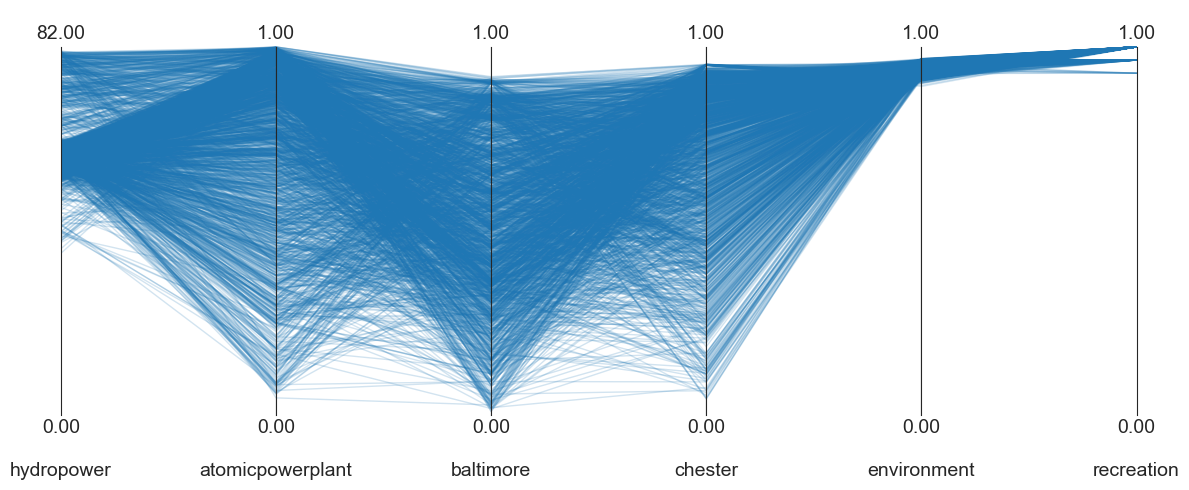

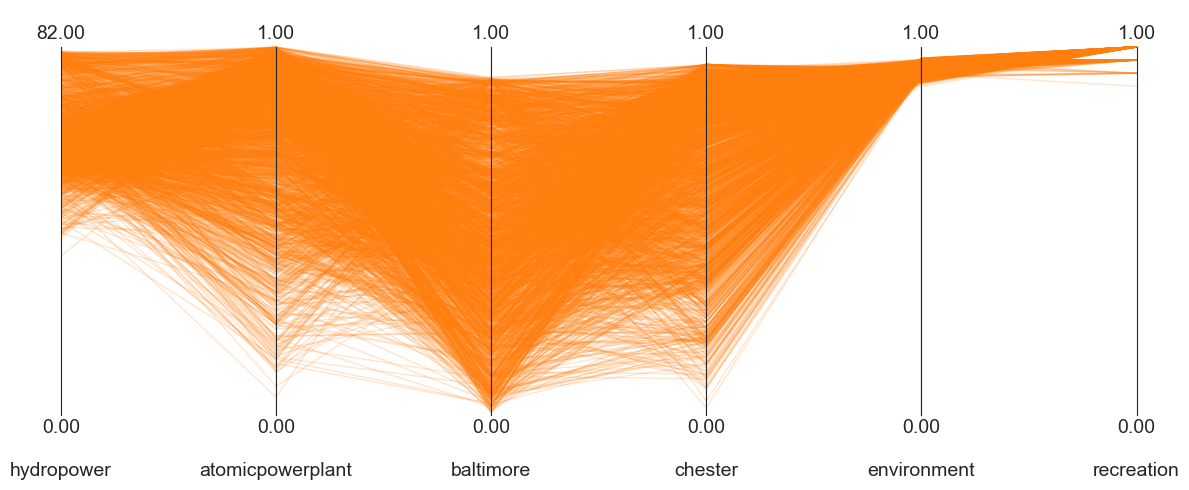

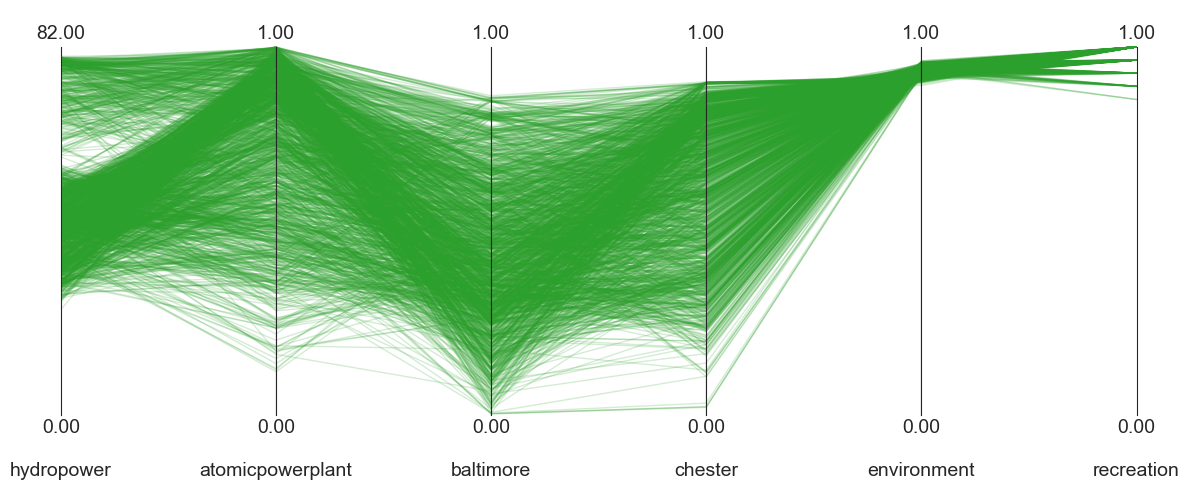

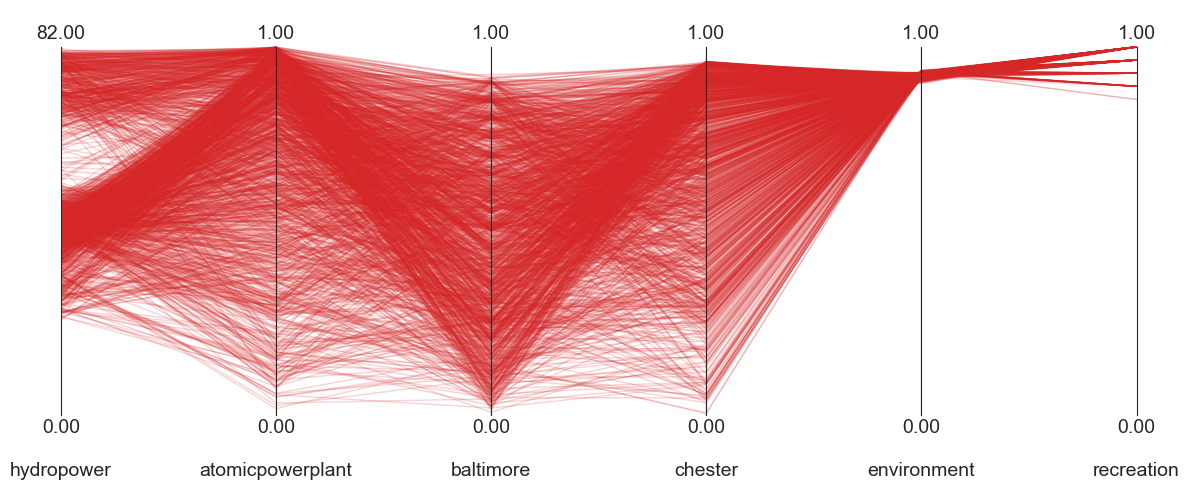

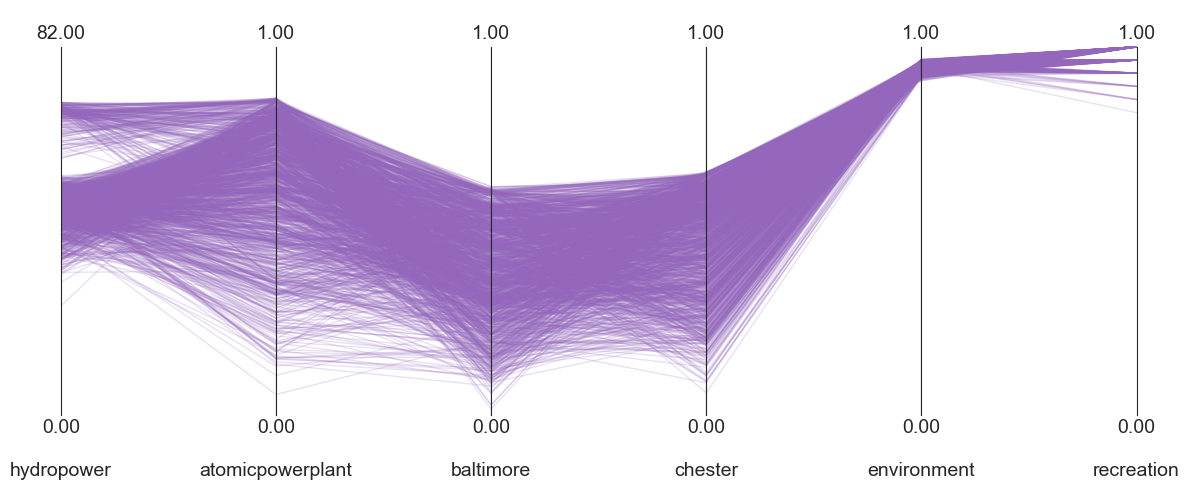

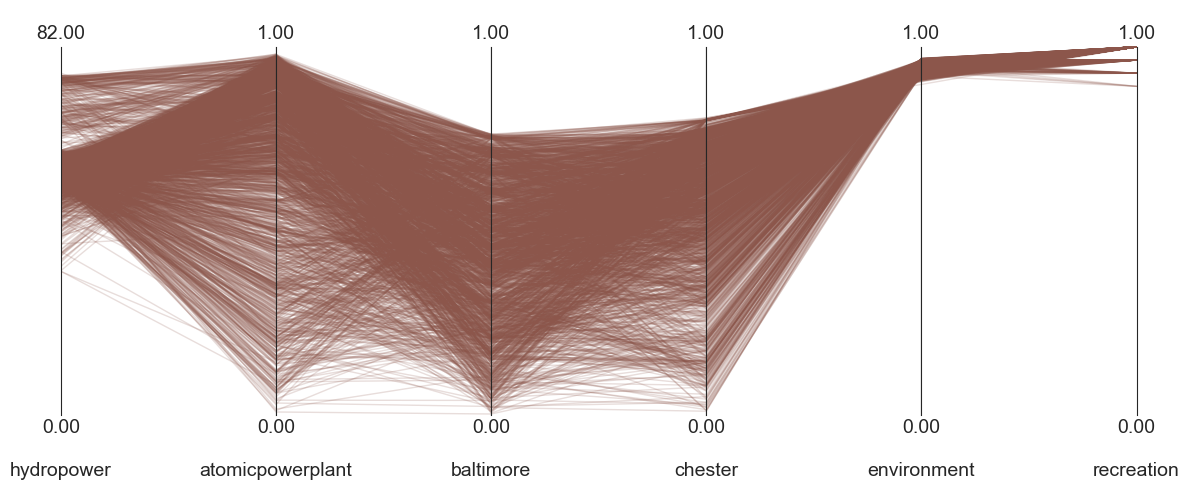

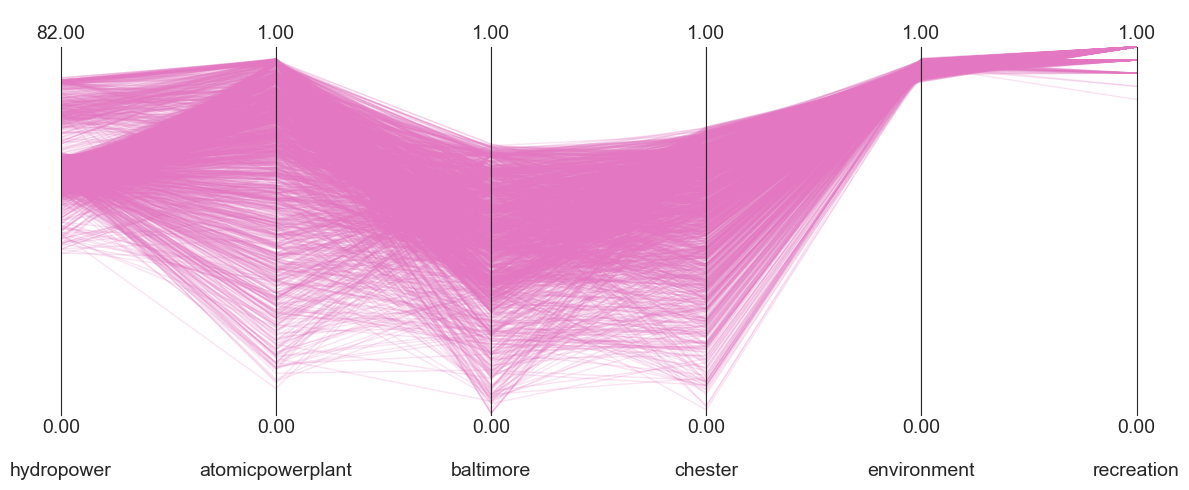

In [5]:
limits = get_limits(pd.concat(pareto_sets.values()))
limits.loc[0] = [0, 0, 0, 0, 0, 0]
limits.loc[1] = [82, 1, 1, 1, 1, 1]

for (k, v), c in zip(pareto_sets.items(), sns.color_palette()):
    axes = ParallelAxes(limits, rot=0)
    axes.plot(v, label=k, lw=1, color=c, alpha=0.2)
    #     axes.legend()
    plt.savefig(f"./figs/{k}/{k}_parcoords_compare.png")
    plt.savefig(f"./figs/{k}/{k}_parcoords_compare.pdf")

plt.show()

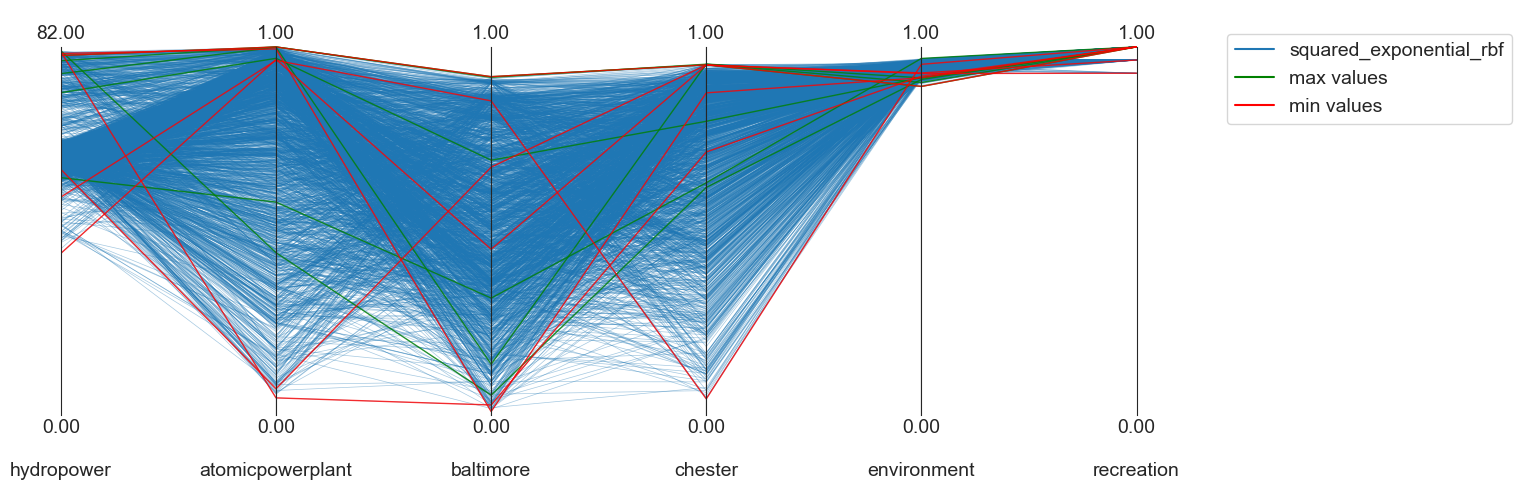

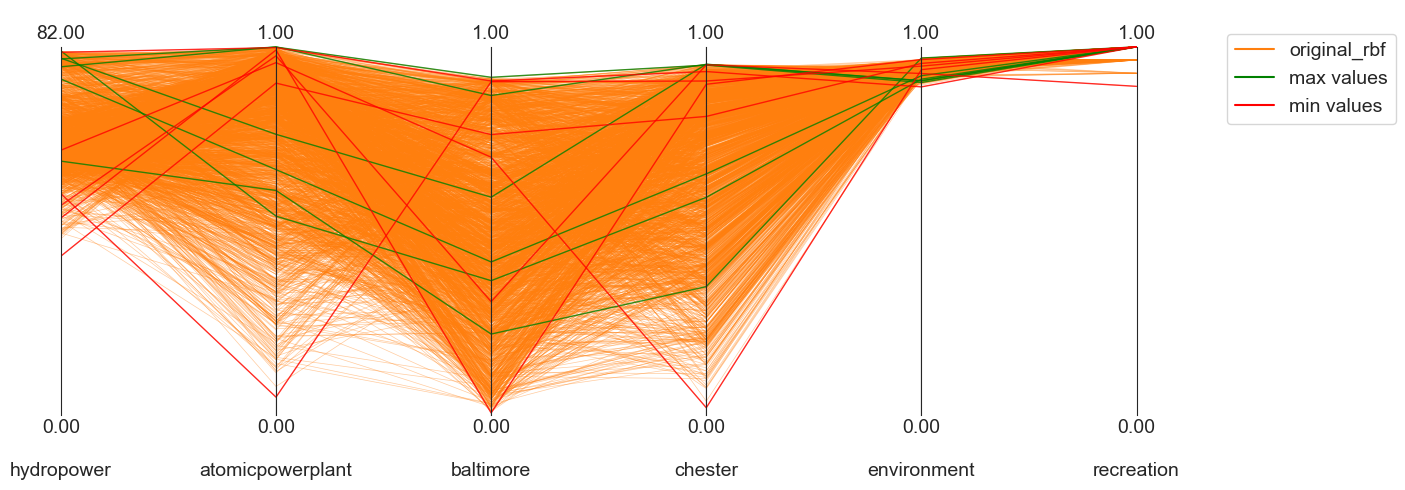

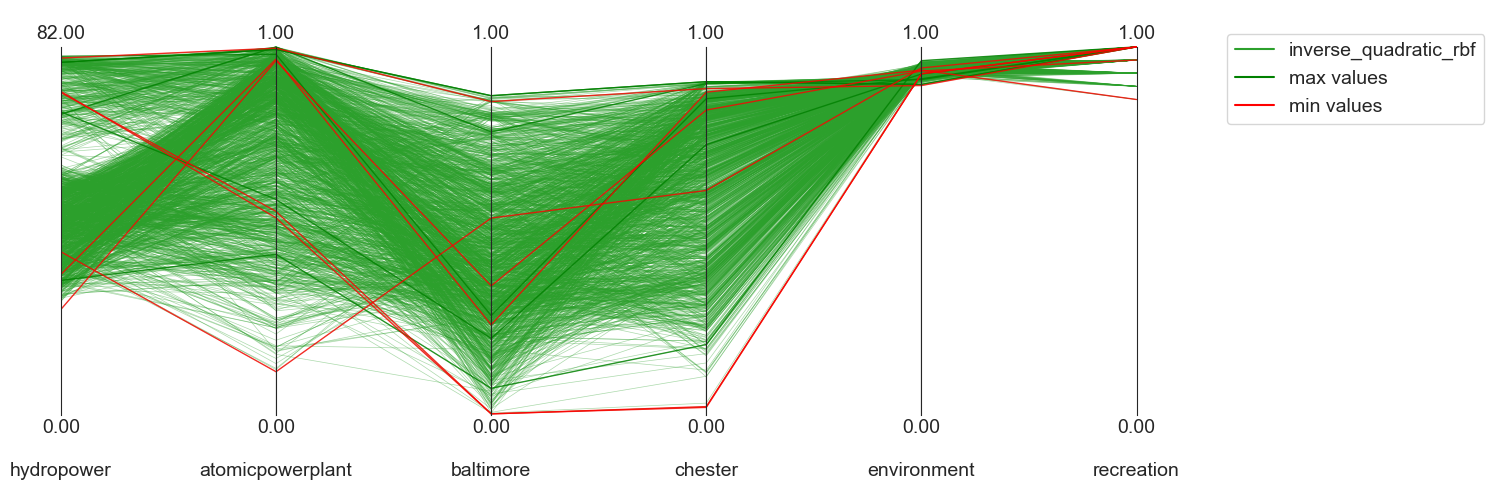

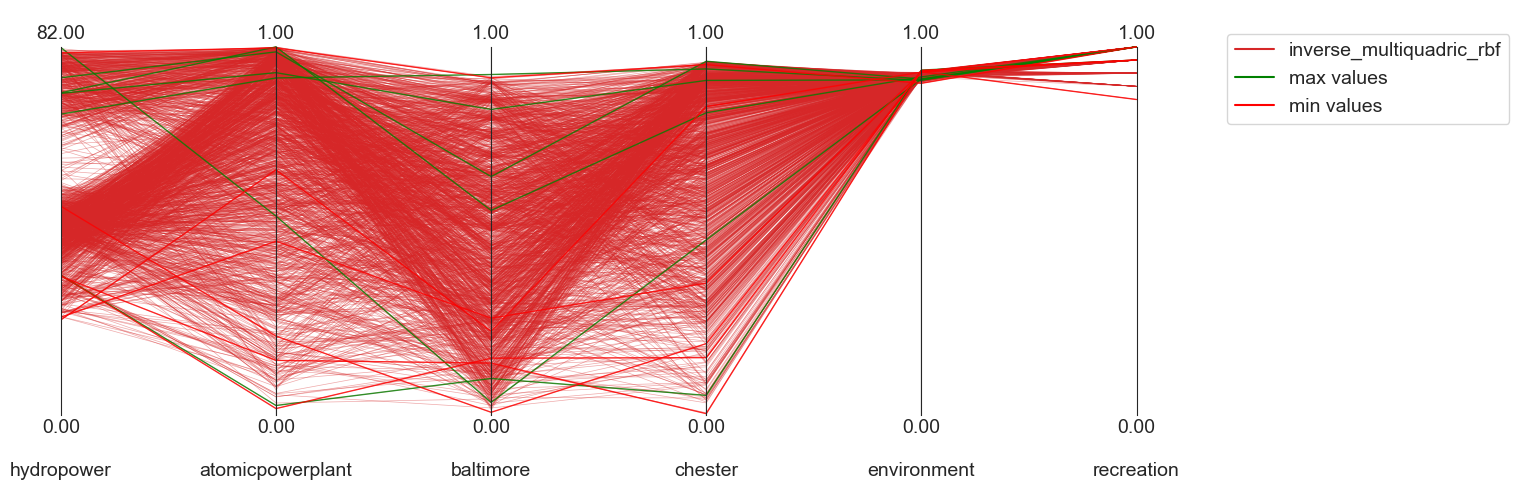

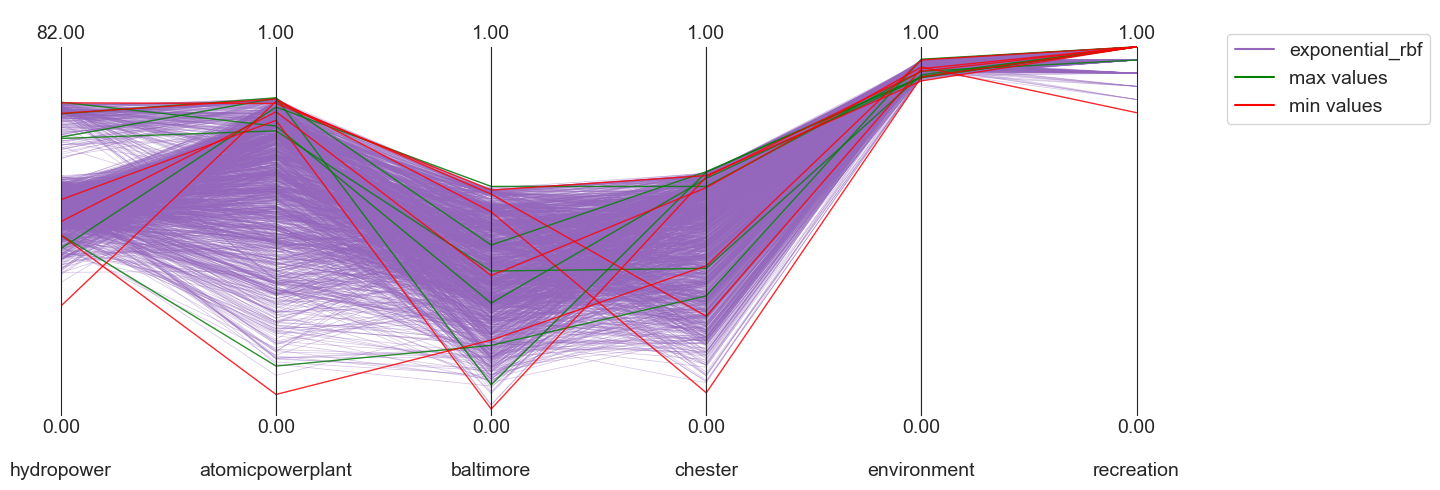

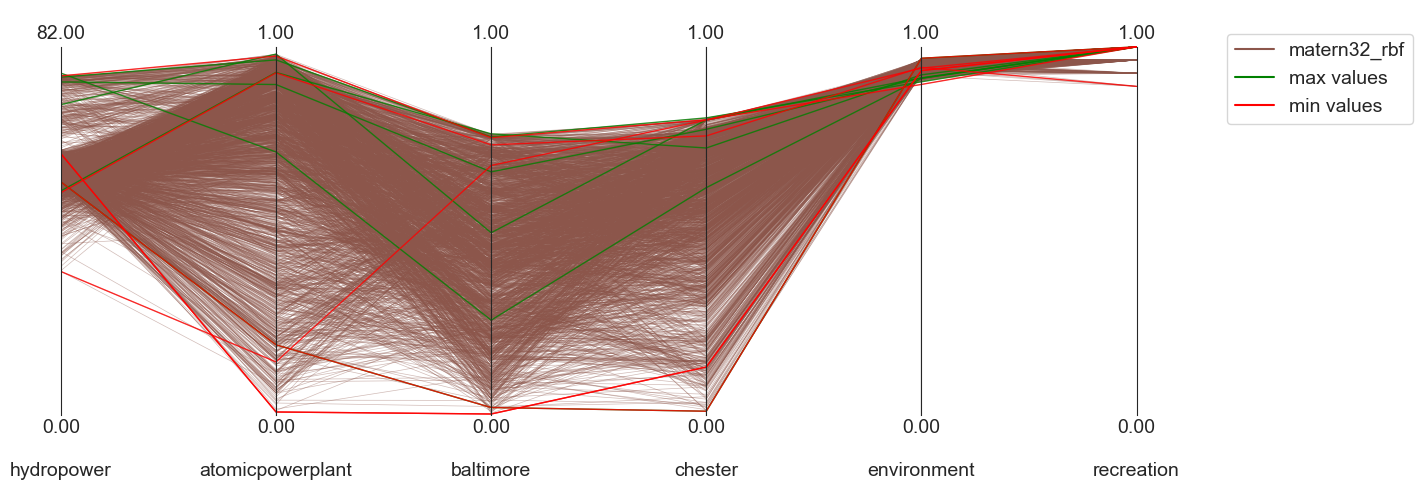

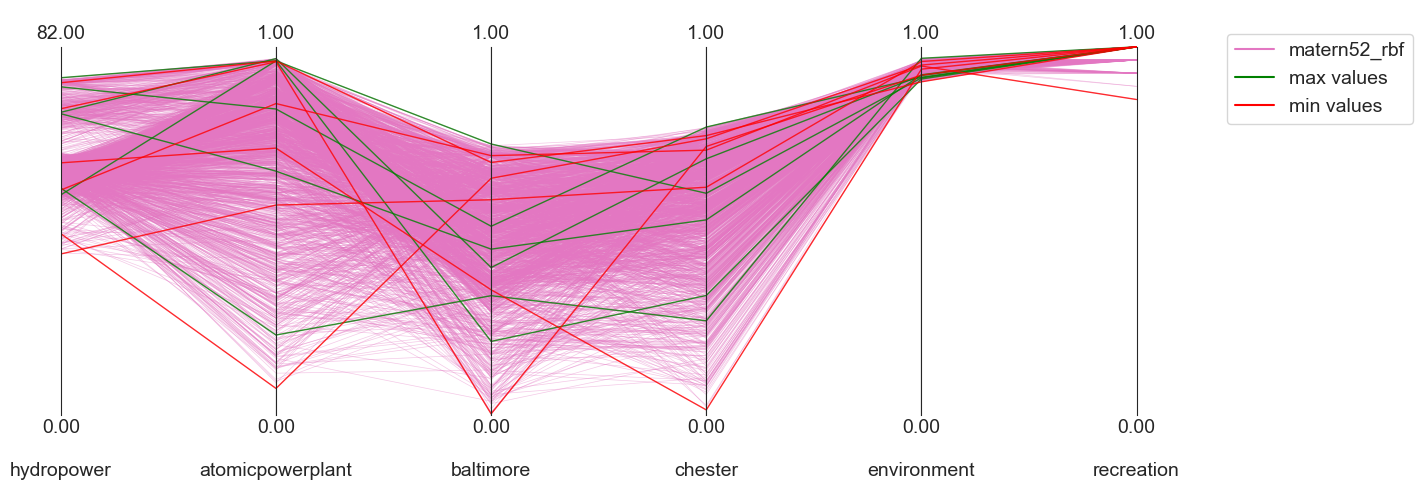

In [6]:
for (k, v), c in zip(pareto_sets.items(), sns.color_palette()):
    df_rbf = pareto_sets[k].copy()

    df_max = pd.concat([df_rbf.loc[i] for i in df_rbf.idxmax()], axis=1).T
    df_min = pd.concat([df_rbf.loc[i] for i in df_rbf.idxmin()], axis=1).T

    limits = get_limits(df_rbf)
    limits.loc[0] = [0, 0, 0, 0, 0, 0]
    limits.loc[1] = [82, 1, 1, 1, 1, 1]
    axes = ParallelAxes(limits, rot=0)
    axes.plot(v, label=k, lw=0.5, color=c, alpha=0.4)
    axes.plot(df_max, label="max values", lw=1, color="green", alpha=0.8)
    axes.plot(df_min, label="min values", lw=1, color="red", alpha=0.8)
    axes.legend()

# plt.savefig(f'figs/{name}/{name}_parcoords.jpg')

In [7]:
for k, v in pareto_sets.items():
    v["rbf"] = k

combined = pd.concat(pareto_sets.values())
combined.head()

hydropower  atomicpowerplant  baltimore   chester  environment  recreation  \
0   71.805019          0.968854   0.692429  0.798047     0.916181         1.0   
1   77.547735          0.997613   0.551329  0.905504     0.914300         1.0   
2   66.402051          0.838943   0.653371  0.624573     0.918140         1.0   
3   74.394864          0.793324   0.637581  0.715839     0.916746         1.0   
4   72.994997          0.983837   0.705766  0.882202     0.913158         1.0   

                       rbf  
0  squared_exponential_rbf  
1  squared_exponential_rbf  
2  squared_exponential_rbf  
3  squared_exponential_rbf  
4  squared_exponential_rbf

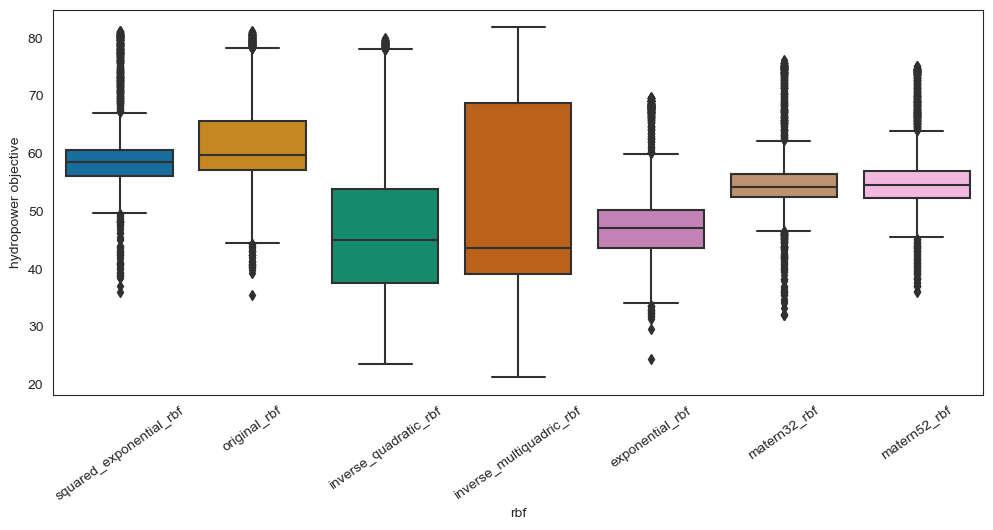

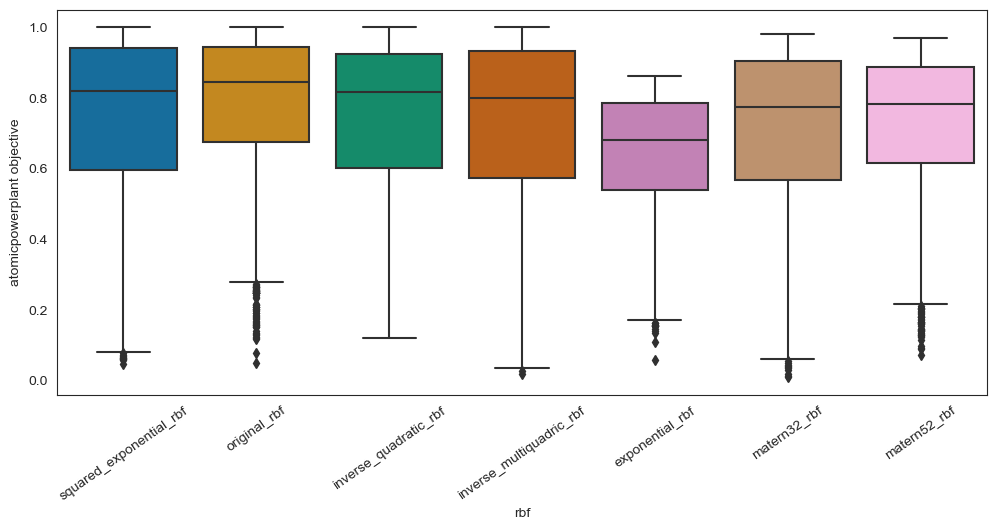

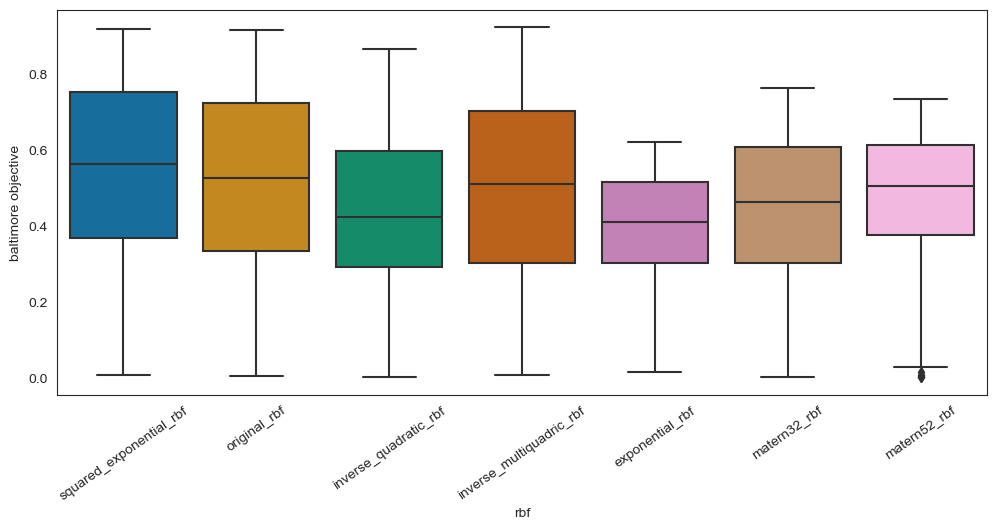

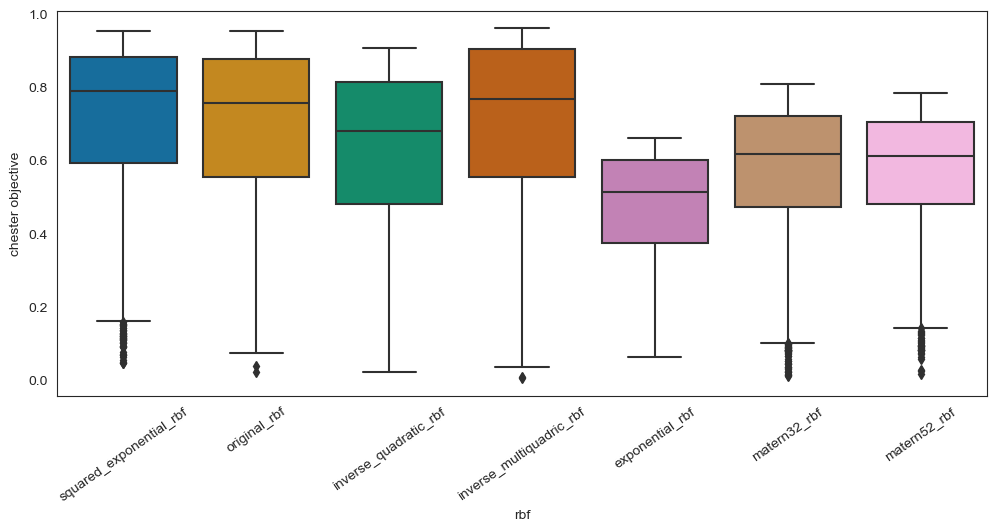

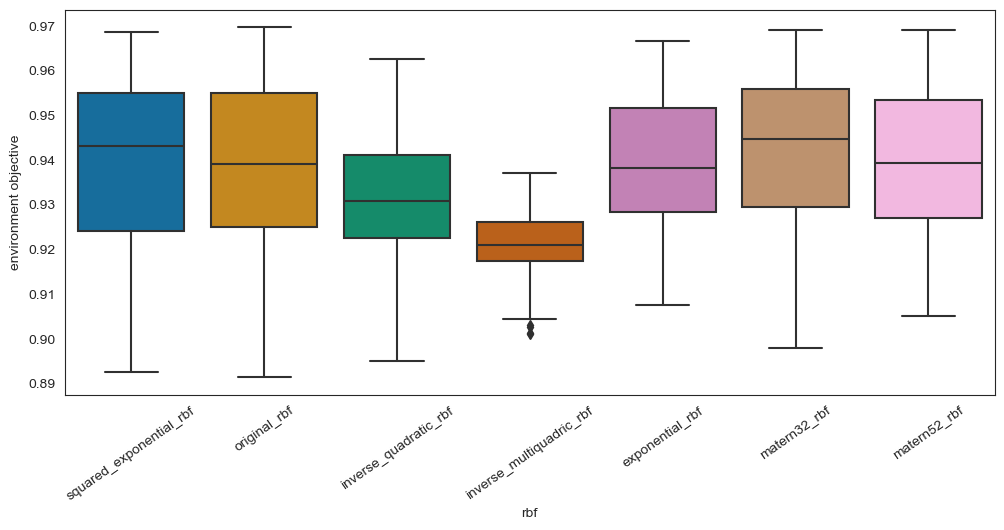

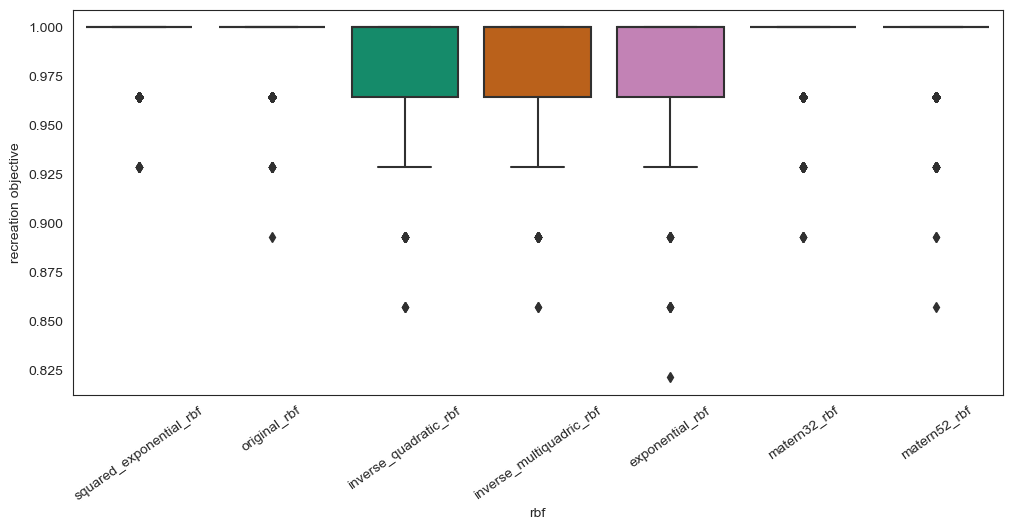

In [8]:
l = []
for n in rbfs:
    l.append(n.__name__)

for entry in combined.columns[0:-1]:
    data = combined[[entry, "rbf"]]
    sns.boxplot(data=data, y=entry, x="rbf", order=l, palette="colorblind")
    plt.ylabel(f"{entry} objective")
    plt.xticks(rotation=35)
    plt.show()

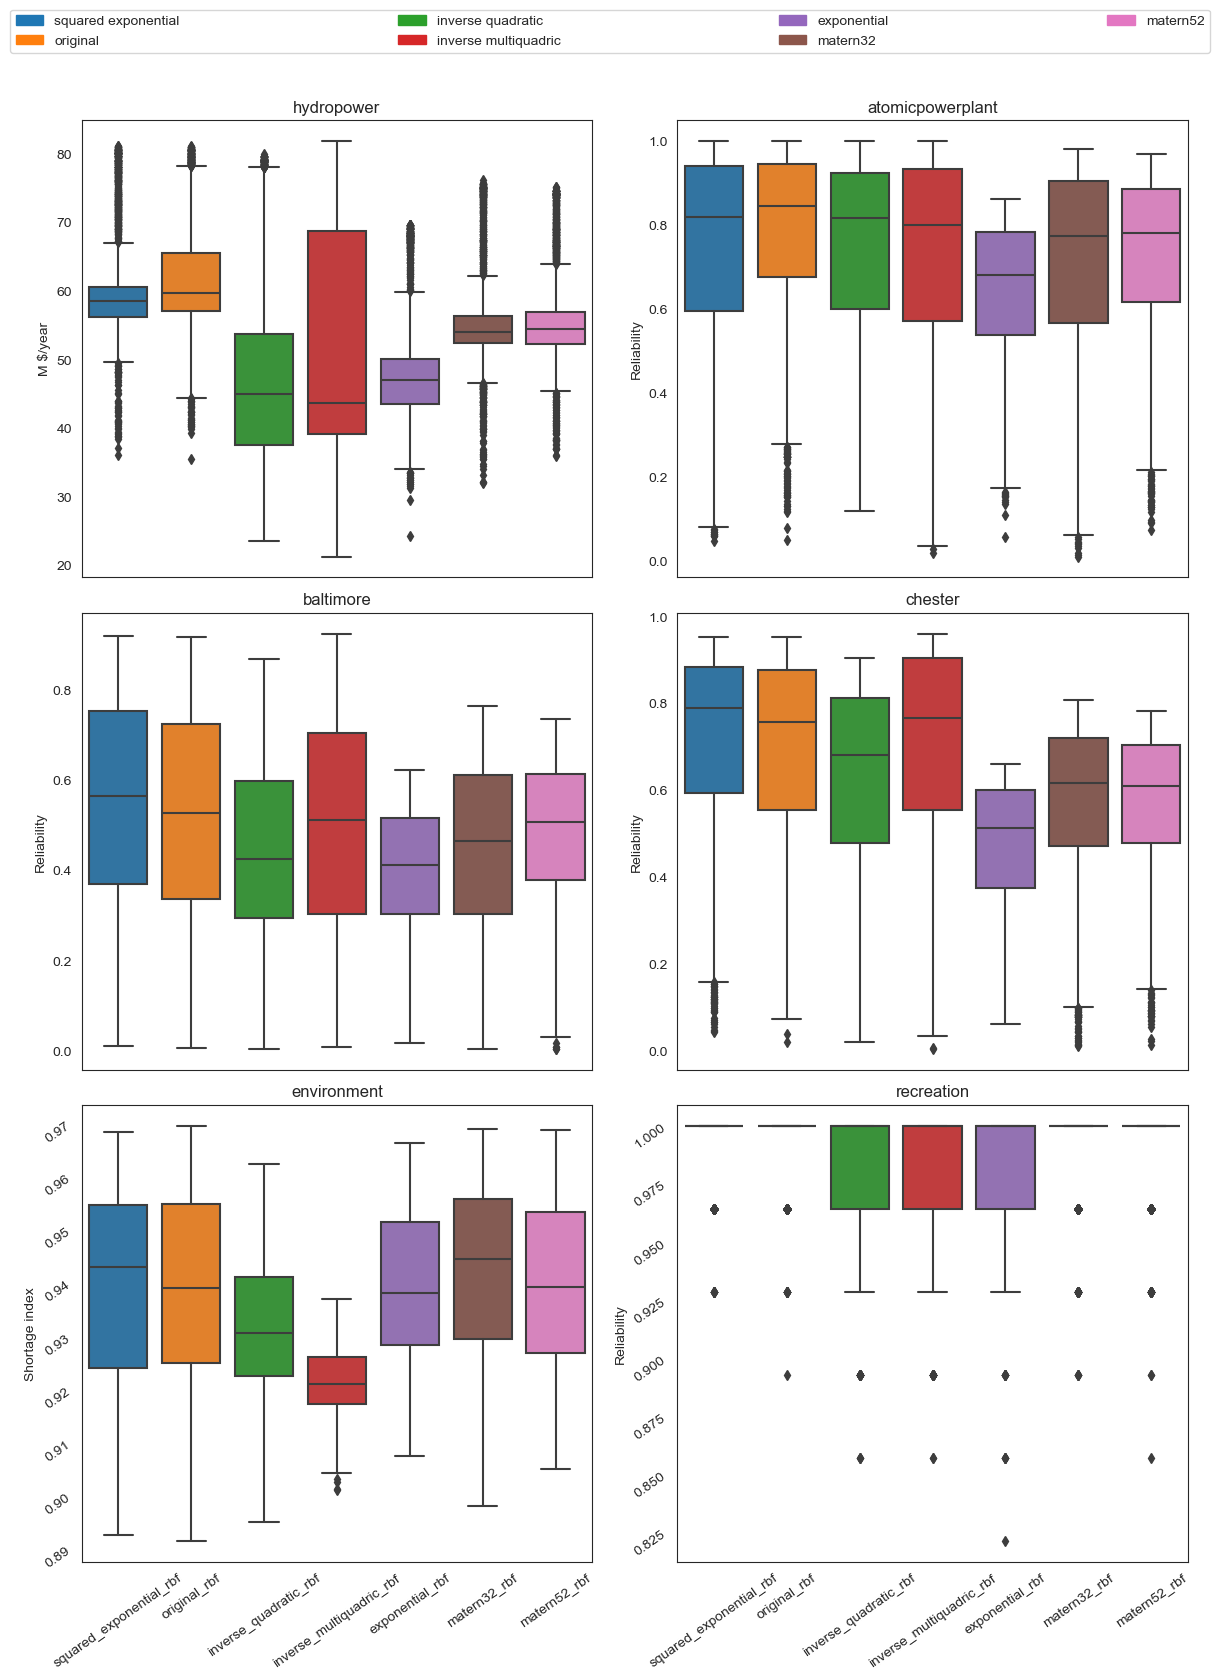

In [9]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12, 16))

for i, entry in enumerate(combined.columns[0:-1]):
    x = i / 2
    data = combined[[entry, "rbf"]]
    if i % 2:
        sns.boxplot(ax=axes[int(x), 1], data=data, y=entry, x="rbf", order=l)
        axes[int(x), 1].set_title(entry)
        axes[int(x), 1].set_ylabel("Reliability")
        axes[int(x), 1].set_xlabel(None)
    else:
        sns.boxplot(ax=axes[int(x), 0], data=data, y=entry, x="rbf", order=l)
        axes[int(x), 0].set_title(entry)
        axes[int(x), 0].set_xlabel(None)
        if x == 0:
            axes[int(x), 0].set_ylabel("M $/year")
        elif x == 2:
            axes[int(x), 0].set_ylabel("Shortage index")
        else:
            axes[int(x), 0].set_ylabel("Reliability")
    axes[2, 0].tick_params(labelrotation=35)
    axes[2, 1].tick_params(labelrotation=35)

# make a single figure level legend
handles = []
colors = sns.color_palette()
for (i, rbf) in enumerate(rbfs):
    # dirty hack to remove underscore from name of rbf
    name = " ".join(rbf.__name__.split("_")[0:-1])
    patch = mpatches.Patch(color=colors[i], label=name)
    handles.append(patch)

fig.legend(
    handles=handles,
    ncol=4,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    mode="expand",
    borderaxespad=0,
)
fig.tight_layout()
plt.savefig(f"./figs/box_plots_compare.png", bbox_inches="tight")
plt.savefig(f"./figs/box_plots_compare.pdf", bbox_inches="tight")